### RatK Day3 two novel recording info

In [1]:
import numpy as np
import subjects
import matplotlib.pyplot as plt
from neuropy import plotting
from neuropy import analyses

sess = subjects.tn.ratKday3[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatK/RatKDay3TwoNovel/RatK_Day3TwoNovel_2019-08-10_04-33-10.xml 
# channels: 134
sampling rate: 30000
lfp Srate (downsampled): 1250



### Probe config
- Copied directly from RatKDay2NSD

In [ ]:
from neuropy.core import Shank, Probe, ProbeGroup

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

# --- cambridge probe -----------
for i in range(8):
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=30,
        y_shift_per_column=[0, -15],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = Probe(shanks)

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

prbgrp.save(sess.filePrefix.with_suffix(".probegroup.npy"))
plotting.plot_probe(prbgrp)

In [ ]:
from neuropy.io import SpykingCircusIO

SpykingCircusIO.write_probe_file(
    sess.filePrefix.with_suffix(".prb"),
    sess.probegroup,
    rmv_badchans=True,
    combine_shanks=True,
)

### Experimental paradigm
- Epochs were estimated from position file. May require further refinement

In [ ]:
file = "/data/Clustering/sessions/RatK/RatKDay3TwoNovel/RatK_Day3TwoNovel_2019-08-10_04-33-10_position.npy"

data = np.load(file, allow_pickle=True).item()
_, ax = plt.subplots()

ax.plot(data["time"], data["y"])

In [ ]:
from neuropy.utils.signal_process import FourierSg
from scipy.ndimage import gaussian_filter1d

smooth = lambda x: gaussian_filter1d(x, sigma=2)

lfp = sess.eegfile.get_signal([55])

spect = FourierSg(lfp, window=2, norm_sig=False)

from neuropy.plotting import plot_signal_heatmap

_, ax = plt.subplots()

# ax.imshow(
#     spect.freq_slice(0.5, 30).traces,
#     aspect="auto",
#     vmax=100000,
#     origin="lower",
#     extent=[spect.time[0], spect.time[-1], 0.5, 30],
# )

ax.plot(spect.time, smooth(spect.theta / spect.delta))
ax.plot(data["time"], data["y"] / 5)

In [ ]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 8940 + 10, 12478, 23243 + 10, 26043],
        "stop": [8898, 12442, 23240, 26041 - 30, 55625],
        "label": ["pre", "maze1", "post1", "maze2", "post2"],
    }
)

Epoch(epochs=epochs).save(sess.filePrefix.with_suffix(".paradigm.npy"))

### Artifact epochs

In [ ]:
signal = sess.eegfile.get_signal([20])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=3, edge_cutoff=1)
artifact_epochs.save(sess.filePrefix.with_suffix(".artifact.npy"))

In [ ]:
signal = sess.eegfile.get_signal([20])
plotting.plot_artifact_epochs(artifact_epochs, signal)

In [ ]:
from neuropy.io import SpykingCircusIO

file = sess.filePrefix.with_suffix(".dead")
SpykingCircusIO.write_epochs(file, artifact_epochs)

### Importing spiketrains from Phy

#### Single folder

In [ ]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/home/bapung/Documents/ClusteringHub/spykcirc/RatK/RatKDay3TwoNovel/RatK_Day3TwoNovel_2019-08-10_04-33-10-1.GUI"
)
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains = phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neuron_type_id = phy_data.cluster_info.q.values
neuron_type = np.ones(len(neuron_type_id), dtype="U5")
neuron_type[neuron_type_id < 4] = "pyr"
neuron_type[neuron_type_id == 6] = "mua"
neuron_type[neuron_type_id == 8] = "inter"


neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms, dtype="object"),
    neuron_type=neuron_type,
    shank_ids=np.array(shank_id).astype(int),
    metadata={"cluster_path": str(cluster_path)},
)

neurons.save(sess.filePrefix.with_suffix(".neurons"))

### MUA

In [ ]:
mua = sess.neurons.get_mua()
mua.save(sess.filePrefix.with_suffix(".mua"))

### Position data

In [ ]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / "position"
opti_data = OptitrackIO(dirname=opti_folder, scale_factor=0.25)

In [ ]:
import pandas as pd
from datetime import datetime

# ------- maze align corection ---------
t_error = [1.2]

# ---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix(".datetime.csv"))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    # sync_time = rec_datetime["sync_nframes"][i] / rec_datetime["sync_rate"][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S") + pd.Timedelta(
        t_error[i], unit="sec"
    )
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
        inclusive="left",
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

# ------- deleting intervals that were deleted from .dat file after concatenating
# ndeletedintervals = rec_datetime.count()["deletedStart (minutes)"]
# del_index = []
# for i in range(ndeletedintervals):
#     tnoisy_begin = int(rec_datetime["deletedStart (minutes)"][i] * 60 * tracking_sRate)
#     tnoisy_end = int(rec_datetime["deletedEnd (minutes)"][i] * 60 * tracking_sRate)

#     del_index.append(np.arange(tnoisy_begin, tnoisy_end))

# del_index = np.concatenate(del_index)
# data_time = np.delete(data_time, del_index)

x, y, z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z, x, y))

position = Position(traces=traces, t_start=0, sampling_rate=opti_data.sampling_rate)
position.save(sess.filePrefix.with_suffix(".position.npy"))


_, ax = plt.subplots()
ax.plot(position.time, position.x)

### Linearize position

In [7]:
0.1 * 120

12.0

/data/Clustering/sessions/RatK/RatKDay3TwoNovel/RatK_Day3TwoNovel_2019-08-10_04-33-10.maze1.linear saved


/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:352: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


/data/Clustering/sessions/RatK/RatKDay3TwoNovel/RatK_Day3TwoNovel_2019-08-10_04-33-10.maze2.linear saved


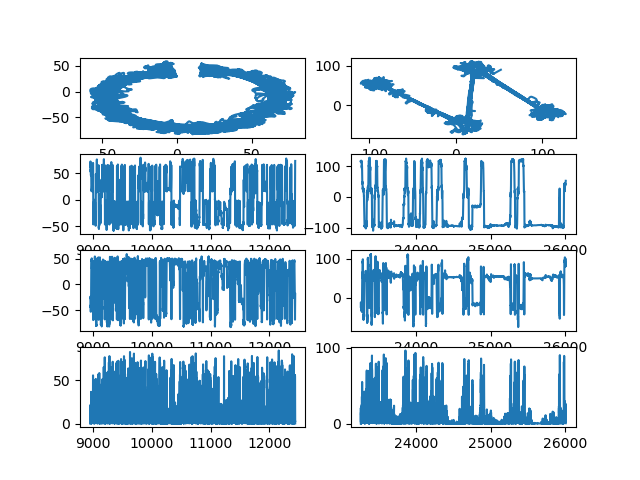

In [9]:
from neuropy.utils import position_util

_, axs = plt.subplots(5, 2)

for i, e in enumerate(["maze1", "maze2"]):
    maze = sess.paradigm[e].flatten()
    maze_pos = sess.position.time_slice(maze[0], maze[1]).get_smoothed(0.1)
    linear_pos = position_util.linearize_position(maze_pos, sample_sec=1).get_smoothed(
        0.1
    )
    linear_pos.save(sess.filePrefix.with_suffix(f".{e}.linear"))

    axs[0, i].plot(maze_pos.x, maze_pos.y)
    axs[1, i].plot(maze_pos.time, maze_pos.x)
    axs[2, i].plot(maze_pos.time, maze_pos.y)
    axs[3, i].plot(maze_pos.time, maze_pos.speed)
    # axs[3, i].plot(linear_pos.time, linear_pos.x)

In [ ]:
_, ax = plt.subplots()
ax.plot(sess.maze2.time, sess.maze2.speed)